# 2. Playing around with media conditions

## Authors
* Arianna Basile, MRC Toxicology Unit, University of Cambridge
* Francisco Zorrilla, MRC Toxicology Unit, University of Cambridge

## Learning outcomes

In this tutorial you will use [cobrapy](https://cobrapy.readthedocs.io/en/latest/) to learn the following:

- **2.1**: Modify growth medium of your reconstruction
- **2.2**: Perform gene essentiality analysis under different conditions
- **2.3**: Case study, simulate the Carbtree effect in yeast

## Setup

In [1]:
# Import packages
import cobra

# Enable autocompleting with tab
%config Completer.use_jedi = False

## 2.1 Growth medium

The availability of nutrients has a major impact on metabolic fluxes and `cobrapy` provides some helpers to manage the exchanges between the external environment and your metabolic model. In experimental settings the “environment” is usually constituted by the growth medium, i.e. the concentrations of all metabolites and co-factors available to the modeled organism. However, constraint-based metabolic models only consider fluxes. Thus, you cannot simply use concentrations since fluxes have the unit `mmol / [gram of dry-cell weight * hour]` (i.e. concentration per gram dry weight of cells and hour).

Also, you are setting an upper bound for the particular import flux and not the flux itself. There are some crude approximations. For instance, if you supply 1 mol of glucose every 24h to 1 gram of bacteria you might set the upper exchange flux for glucose to `1 mol / [1 gDW * h]` since that is the nominal maximum that can be imported. There is no guarantee however that glucose will be consumed with that flux. Thus, the preferred data for exchange fluxes are direct flux measurements as the ones obtained from timecourse exa-metabolome measurements for instance.

So how does that look in COBRApy? The current growth medium of a model is managed by the medium attribute.

In [2]:
# Import model
model_yeast=cobra.io.read_sbml_model("iMM904.xml.gz")

# Extract media information
medium=model_yeast.medium

# Show uptake bounds for extracellular media
medium

{'EX_fe2_e': 999999.0,
 'EX_glc__D_e': 10.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 2.0,
 'EX_pi_e': 999999.0}

This will return a dictionary that contains the upper flux bounds for all active exchange fluxes (the ones having non-zero flux bounds). Right now we see that we have enabled aerobic growth. 
Let's optimize to check the growth in the given medium.

In [3]:
# Solve FBA
model_yeast.optimize()

# Show growth rate with glucose as carbon source
model_yeast.objective.value

0.28786570370401793

You can modify a growth medium of a model by assigning a dictionary to `model.medium` that maps exchange reactions to their respective upper import bounds. Let's edit the medium to have ethanol as carbon source instead of glucose.

In [4]:
# Make a copy of the original model
model_yeastv2=model_yeast.copy()

# Extract media information
medium = model_yeastv2.medium

# Define new media uptake bounds
medium["EX_glc__D_e"] = 0
medium["EX_etoh_e"] = 1.0

# Update new media uptake bounds in model copy
model_yeastv2.medium = medium

# Show new uptake bounds
model_yeastv2.medium

{'EX_etoh_e': 1.0,
 'EX_fe2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 2.0,
 'EX_pi_e': 999999.0}

As we can see, the glucose in our medium has been replaced by ethanol. Let's check how it influences the growth rate.

In [5]:
# Solve FBA with new uptake bounds
model_yeastv2.optimize()

# Show growth rate with ethanol as carbon source
model_yeastv2.objective.value

0.027542115993883887

The growth rate is reduced when growing on ethanol compared to glucose. In conclusion, we have the same metabolic reconstruction (`iMM904`), simulated under two different media conditions using different carbon sources. `model_yeast` is growing with glucose as a carbon source while `model_yeastv2` is using ethanol.

### Questions

1. Can the yeast model grow using lactose as a carbon source? Why?
2. What happens when you lower the uptake rate of ammonium? How about when it is set to 0?
3. Can you quantify the changes in growth rate after adding an amino acid of your choice to the media?

## 2.2 Gene essentiality

A gene is considered essential if restricting the flux of all reactions that depend on it to zero causes the objective, e.g., the growth rate, to also be zero, fall below a given threshold, or result in infeasible solutions.

Now we will use the function `find_essential_genes` to find essential genes in both conditions, extract the IDs of the genes, and compare the two lists. Can you do it on your own?

First lets check the model growing with ethanol as a carbon source:

In [6]:
# Find essential genes for model growing under ethanol condition
essential_genes_v2=cobra.flux_analysis.variability.find_essential_genes(model_yeastv2)

# Get genes IDs
id_essential_genes_v2=[gene.id for gene in essential_genes_v2]

# Print number of esssential genes
print("Essential genes with ethanol carbon source: ",len(id_essential_genes_v2))

Essential genes with ethanol carbon source:  154


Next lets check the model growing with glucose as a carbon source:

In [7]:
# Find essential genes for model growing under glucose condition
essential_genes=cobra.flux_analysis.variability.find_essential_genes(model_yeast)

# Get genes IDs
id_essential_genes=[gene.id for gene in essential_genes]

# Print number of essential genes
print("Essential genes with glucose carbon source: ",len(id_essential_genes))

Essential genes with glucose carbon source:  110


Check how large the intersect is between the two lists:

In [8]:
a=list(set(id_essential_genes_v2) & set(id_essential_genes))
print("Interect of essential genes between conditions: ",len(a))

Interect of essential genes between conditions:  110


Lets check which genes are unique to each condition:

In [9]:
print("Essential genes unique to ethanol growth condition:",len(list(set(id_essential_genes_v2) - set(id_essential_genes))))
list(set(id_essential_genes_v2) - set(id_essential_genes))

Essential genes unique to ethanol growth condition: 44


['Q0130',
 'YBL099W',
 'YPL271W',
 'YGL191W',
 'YCR012W',
 'YFR033C',
 'YHR001W_A',
 'YML081C_A',
 'YER065C',
 'YBR196C',
 'YMR256C',
 'YGR183C',
 'YBL045C',
 'YKL060C',
 'YPL078C',
 'YLR038C',
 'YDL067C',
 'YDR050C',
 'Q0080',
 'YLR377C',
 'YPR191W',
 'Q0250',
 'YDL004W',
 'YJR121W',
 'YEL024W',
 'YDL181W',
 'Q0275',
 'YOR065W',
 'YDR529C',
 'YDR377W',
 'Q0045',
 'YDR298C',
 'YHR051W',
 'YKR097W',
 'YBR039W',
 'YLR295C',
 'YGL187C',
 'YLR395C',
 'Q0105',
 'Q0085',
 'YPL262W',
 'YLL041C',
 'YKL016C',
 'YJL166W']

In [10]:
print("Essential genes unique to glucose growth condition:",len(list(set(id_essential_genes) - set(id_essential_genes_v2))))
list(set(id_essential_genes) - set(id_essential_genes_v2))

Essential genes unique to glucose growth condition: 0


[]

### Questions

1. Why there are more essential genes for growth on ethanol than for growth on glucose? 
2. What are the features of the genes essential only for growth on ethanol?
3. Choose an essential gene unique to growth in ethanol and search the literature for its function. Does it make sense to you that it is essential?

## 2.3 Simulating the Crabtree effect 



Yeast central carbon metabolic pathways: all short-term Crabtree positive yeasts possess an upregulated aerobic (blue) and anaerobic (red) glycolytic pathway, even under fully aerobic conditions, when energy and carbon-source is limiting. At low glucose uptake rates, yeasts cells are purely respiring and there is a carbon-flux only through glycolysis (GF) and respiration (RF). Upon a sudden glucose excess condition (glucose pulse), the glycolytic flux will exceed the respiratory flux, which results in a fermentative flux (FF) and ethanol production. In other words, it appears as if slowly dividing short-term Crabtree positive cells, with little food around are already equipped with a strong energy producing apparatus, for rapid glucose consumption and energy production.

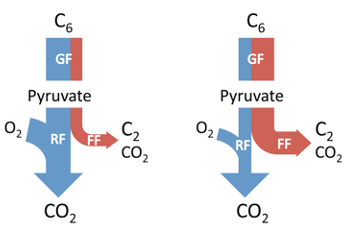
(Adapted from <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0116942">Hagman and Piškur, 2015</a>)

To simulate the Carbtree effect, we consider a fixed amount of glucose and different concentrations of oxygen in our medium. 

In [11]:
# Create copy of model
model_yeastv3=model_yeast.copy()

# Define range of oxygen uptake rates
oxygen_uptakes=range(5,400,10)
oxygen_uptakes = [ x / 100 for x in oxygen_uptakes]

# Define ethanol production vector
etoh_prod=[]

# Simulate under varying oxygen uptake rates, fixed glucose
for flux in oxygen_uptakes:
    medium = model_yeastv3.medium
    medium["EX_glc__D_e"] = 15
    medium["EX_o2_e"]=flux
    model_yeastv3.medium = medium
    opt=model_yeastv3.optimize()
    etoh_prod.append(opt.fluxes["EX_etoh_e"])


Plot results

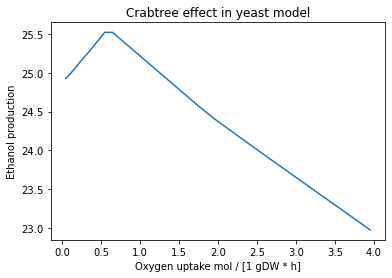

In [12]:
# Import plotting library
import matplotlib.pyplot as plt

# Define plot
x_axis=oxygen_uptakes
y_axis=etoh_prod
plt.plot(x_axis, y_axis)
plt.title('Crabtree effect in yeast model')
plt.xlabel('Oxygen uptake mol / [1 gDW * h]')
plt.ylabel('Ethanol production')
plt.show()

In [13]:
#if you want you can try similar analyses using different carbon sources, e.g. D-mannose
#type your code here, solutions in the html

### Questions:

1. Can you explain the observed behavior in the plot above?
2. Try playing around with other media components, for example, what happens if you keep oxygen fixed and vary glucose?
3. What is the Warburg effect? What is the medical relevance of this phenomenon?
